In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom as dicom
%matplotlib inline 

In [2]:
from PIL import Image, ImageDraw
from IPython.core.debugger import set_trace

In [3]:
from os import listdir
from os.path import isfile, join, abspath, isdir
from sys import path

In [4]:
module_path = abspath(join('..'))
if module_path not in path:
    path.append(module_path)

In [5]:
from prep.parsing import *
from prep.parser import Parser
import cv2

/home/yesu/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


## 1. Visualize one example of image, inner contour and outer contour 

In [309]:
outers = listdir(join(processed_dir, 'o_masks', '0'))

In [310]:
testfile = outers[1]

In [345]:
image_test = cv2.imread(join(processed_dir, 'images', '0', testfile), 0)
image_test = image_test /np.max(image_test)

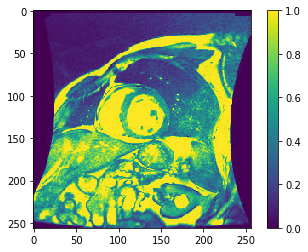

In [347]:
plt.imshow(image_test);plt.colorbar();

In [348]:
def to_binary_mask(mask, thresh = 128):
    return (1*mask > thresh).astype(int)

In [349]:
outer_test = to_binary_mask(cv2.imread(join(processed_dir, 'o_masks', '0', testfile), 0))

In [350]:
inner_test = to_binary_mask(cv2.imread(join(processed_dir, 'i_masks', '0', testfile), 0))

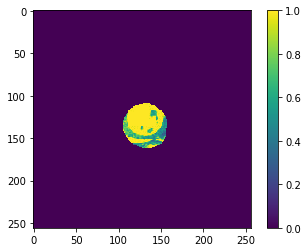

In [351]:
plt.imshow(np.multiply(outer_test, image_test));plt.colorbar();

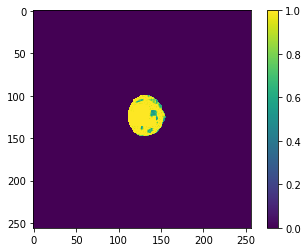

In [352]:
plt.imshow(np.multiply(inner, image_test));plt.colorbar();

In [372]:
# this should not be necessary if inner is perfectly included in the outer contour, but it is not the case.
# therefore, this find the intersection, and from here on, we assume the intersection is the blood pool.
intersect = np.multiply(inner, outer)

In [373]:
# areas in outer contour that is not in the inner contour, supposedly to be only the muscle. but it is not the case.
between = np.multiply(1-inner, outer)

In [355]:
error = np.multiply(1-outer, inner);

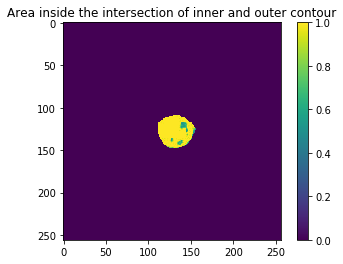

In [356]:
plt.imshow(np.multiply(image_test, intersect));plt.colorbar();
plt.title('Area inside the intersection of inner and outer contour');

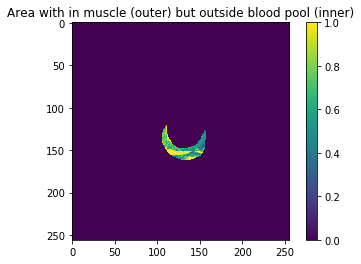

In [357]:
plt.imshow(np.multiply(image_test, between));plt.colorbar();
plt.title('Area with in muscle (outer) but outside blood pool (inner)');

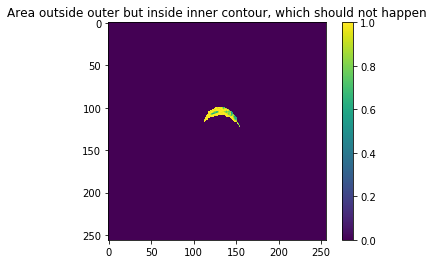

In [358]:
plt.imshow(np.multiply(image_test, error));plt.colorbar();
plt.title('Area outside outer but inside inner contour, which should not happen');

## 2. Get Stats of the intensity distribution of outer and inner contours

In [359]:
def getIntensityStats(image, inner, outer):
    """
    Given the image, the inner mask and the outer mask
    generate the stats about the intensity distribution 
    of blood pool vs heart muscle
    Arguments:
        image -- image
        inner, outer -- bool type 2d numpy array with the same size as the image
    """
    inner = inner.astype(int)
    outer = outer.astype(int)
    blood_msk = np.multiply(inner, outer)
    muscle_msk = np.multiply(1-inner, outer)
    blood = np.multiply(image, blood_msk)
    muscle = np.multiply(image, muscle_msk)
    return np.median(blood[blood > 0]), np.median(muscle[muscle > 0]), np.std(blood[blood > 0]), np.std(muscle[muscle > 0])

In [360]:
median_intensities = []
std_intensities = []
for fname in outers:
    outer = to_binary_mask(cv2.imread(join(processed_dir, 'o_masks', '0', fname), 0))
    inner = to_binary_mask(cv2.imread(join(processed_dir, 'i_masks', '0', fname), 0))
    img = cv2.imread(join(processed_dir, 'images', '0', fname),0)
    img = img/np.max(img)
    allstats = getIntensityStats(img, inner, outer)
    median_intensities.append(allstats[:2])
    std_intensities.append(allstats[2:])

In [361]:
blood_md, muscle_md = zip(*median_intensities)

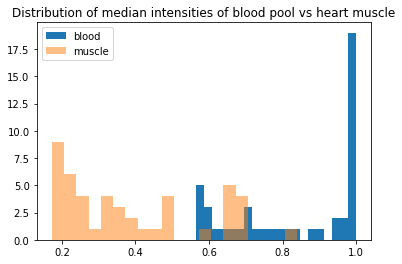

In [362]:
ax0 = plt.gca()
ax0.hist(blood_md, bins = 20, label='blood');
ax0.hist(muscle_md, bins = 20, label = 'muscle', alpha = 0.5);
plt.title('Distribution of median intensities of blood pool vs heart muscle');
ax0.legend();

In [363]:
diff_median = [x - y for x,y in median_intensities]

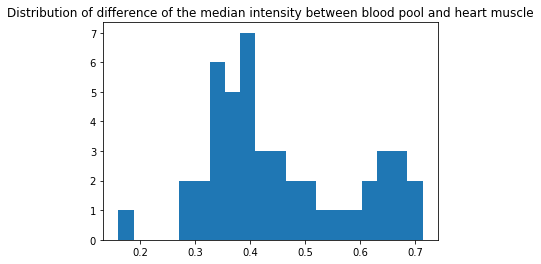

In [364]:
plt.hist(diff_median, bins = 20);
plt.title('Distribution of difference of the median intensity between blood pool and heart muscle');

In [365]:
blood_std, muscle_std = zip(*std_intensities)

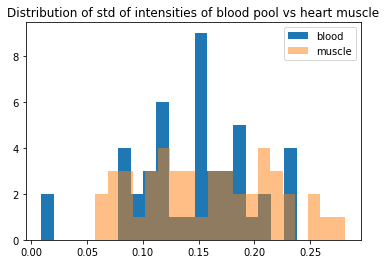

In [366]:
ax0 = plt.gca()
ax0.hist(blood_std, bins = 20, label='blood');
ax0.hist(muscle_std, bins = 20, label = 'muscle', alpha = 0.5);
plt.title('Distribution of std of intensities of blood pool vs heart muscle');
ax0.legend();

## 3. Test one possible path of segmentation 

Given the analysis above, we conclude that thresholding by intensity can work with segmentation for most of the images in the set, however, it might not be perfect due to the fact that some images have relatively small gap between the intensity of blood vs heart muscle. 

Concretely, one possible path of segmentation can be:
1. Find the maximum intensity within the outer contour
2. Threshold based on 0.75 * max Intensity (above that is blood, and therefore forms the inner contour), 0.75 is based on the fact that most blood pool intensity standard deviation are below 0.25.

In [367]:
outer_image = np.multiply(image_test, outer_test)

In [368]:
generated_inner_msk = outer_image >= outer_image.max()*.75

In [369]:
generated_inner_msk.dtype

dtype('bool')

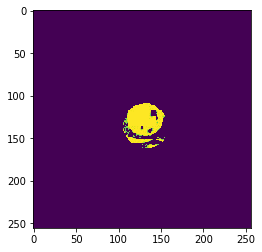

In [371]:
plt.imshow(np.multiply(image_test, generated_inner_msk))

## Summary:
    1. The inner contour is not always within the outer contour, which is not ideal.
    2. Blood pool evidently has stronger signal compared to muscle, supported by the statistical analysis of the median and std of the intensities.
    3. From the stats distribution we conclude a possible threshold that should work in most cases to isolate the blood pool from within the outer contour.
    4. The outcome is raw, should be followed by morphological operations.